---
title: Comparing Uniform Haplotype Enformer gene expression prediction performance 
author: Sabrina Mi
date: 1/24/2024
---

## Setup

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import os
import time
columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']

2024-02-08 04:28:02.993273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 04:28:08.883423: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:/soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/so

In [6]:
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
individuals = list(pred_expr.index)
gene_annot = pd.read_csv("/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/gene_mapping.txt")
genes_df = gene_annot[gene_annot['gene'].isin(pred_expr.columns)]

In [7]:
probabilities_dir = "/eagle/AIHPC4Edu/sabrina/Br_genotype_probabilities"
reference_dir = "/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/human"
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders_v2"
run_dir = "/home/s1mi/Github/deep-learning-in-genomics/posts/2024-01-10-epigenomexcan-vs-enformer-significant-genes"

In [100]:
def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 256
        end = tss + 256
        indices = (prob['POS'] >= start) & (prob['POS'] <= end)
        # if there are no snps within 256 bp of the tss
        if (sum(indices) == 0):
            end_index = (prob['POS'] > tss).idxmax()
            pr = prob.iloc[[end_index-1,end_index],:]
        # otherwise average haplotype probabilities in region
        else:
            pr = prob[(prob['POS'] >= start) & (prob['POS'] <= end)]
        pr = pr.drop(columns='POS').mean(axis=0).values
        with h5py.File(reference_file, "r") as hf:
            ref_matrix = hf[gene][:, 446:450, 4980]
        output = pr @ ref_matrix
        predictions.append(np.average(output))
    return predictions

### Compute Haplotype-Combination Gene Expression

In [ ]:
# Split into batches by chromosome
for chr, group in genes_df.groupby("chromosome"):
    print(f"{chr}: {len(group)} genes")
    reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
    probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
    output_file = os.path.join(output_dir, f"{chr}_selected_genes.csv")
    # If individual has gene expression data, remove from list
    if os.path.exists(output_file):
        haplo_expr = pd.read_csv(output_file, index_col=0)
        completed_individuals = haplo_expr.dropna().index
        individuals = pred_expr.index.difference(completed_individuals)
    else:
        haplo_expr = pd.DataFrame(columns=group['gene'], index=pred_expr.index)
        individuals = haplo_expr.index
    with h5py.File(os.path.join(probabilities_dir, f"{chr}_probabilities.h5"), "r") as input:
        tic = time.perf_counter()
        for index, individual in enumerate(individuals):
            prob = pd.DataFrame(input[individual][:], columns=columns)
            predictions = run_sample_predictions(prob, reference_file, group)
            haplo_expr.loc[individual] = predictions
            if ((index + 1) % 20 == 0):
                toc = time.perf_counter()
                print(f"Batch {(index + 1)//20}: {(toc - tic)/60} minutes")
                haplo_expr.to_csv(output_file)
    haplo_expr.to_csv(output_file)


## Analysis

**Import Libraries**

In [102]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
colors = sns.color_palette("pastel")

**Reformat Data**

In [103]:
# read observed, Enformer predicted expression and cross-population correlation by gene
tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
cors = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_pearson_corr_human.csv", index_col = 0)

/tmp/ipykernel_144042/3001682009.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')


In [108]:
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders_v2"
outputs = []
for file in os.listdir(output_dir):
    df = pd.read_csv(os.path.join(output_dir, file), index_col=0)
    outputs.append(df)
haplo_expr = pd.concat(outputs, axis=1)

In [109]:
# subset to genes with fast enformer predictions
gene_list = haplo_expr.columns.intersection(cors.index)
cors = cors.loc[gene_list]
obs_expr = tpm.loc[gene_list].drop(columns=["#chr", "start", "end"]).transpose()
pred_expr = pred_expr[gene_list]
haplo_expr = haplo_expr[gene_list]

## Evaluating Mean Haplotype Probability Enformer against Enformer

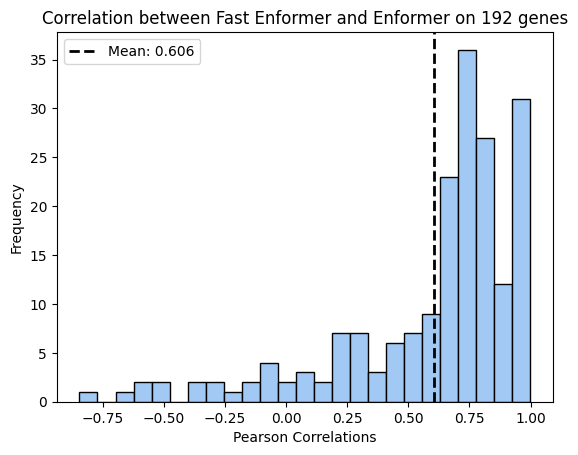

In [110]:
output_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in gene_list:
    individuals = haplo_expr[gene].dropna().index
    corr, pval = stats.pearsonr(pred_expr.loc[individuals, gene].values, haplo_expr.loc[individuals, gene].values)
    output_cors.loc[gene] = [corr, pval]
# Plot a pearson_corr_by_gene["human"]
plt.hist(output_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Enformer on {len(gene_list)} genes')
plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()